In this notebook, we compute invariant sets for the 3D system with univariate input of Example ?.? of [???].
We need to select an semidefinite programming solver to find the invariant set. A complete list of available solvers is [available here](https://www.juliaopt.org/JuMP.jl/stable/installation/#Getting-Solvers-1).

In [1]:
using MosekTools
using JuMP
solver = with_optimizer(Mosek.Optimizer, QUIET=true)

OptimizerFactory(Mosek.Optimizer, (), Base.Iterators.Pairs(:QUIET => 1))

We first define the safe sets and input sets for our system using [Polyhedra](https://github.com/JuliaPolyhedra/Polyhedra.jl).

In [2]:
using Polyhedra
G = [ 0.8304    0.9608   -0.6607
     -0.5279    0.7682   -0.2108
     -0.9722   -0.5355   -0.7135
      0.1539   -0.7305    0.8130
      0.0238   -0.4138   -0.4418
      0.2655    0.8882   -0.8859
     -0.6859    0.4937   -0.0190
     -0.1077   -0.8368    0.8729
     -0.8887    0.0932    0.3885
     -0.4192   -0.9132    0.3742
     -0.1649   -0.9065    0.1010
      0.2987    0.9829    0.9178
      0.6361   -0.6986   -0.7053]
F =  [0.0366
      0.1687
      0.8988
      0.0233
      0.3298
      0.1828
      0.2025
      0.1244
      0.2920
      0.3577
      0.3586
      0.3896
      0.5930]
safe_set = polyhedron(hrep(G, F), DefaultLibrary{Float64}(solver))
cheby_center, cheby_radius = chebyshevcenter(safe_set, solver)
using SemialgebraicSets
input_set = FullSpace()

Algebraic Set defined by no equality


We new define the dynamic of our system and create it using [MathematicalSystems](https://github.com/JuliaReach/MathematicalSystems.jl/).

In [3]:
using MathematicalSystems
A = [ 0  1 -2
      3 -4  5
     -6  7  8]
B = reshape([-1; 2; 4], 3, 1)
system = ConstrainedLinearControlDiscreteSystem(A, B, safe_set, input_set)

ConstrainedLinearControlDiscreteSystem{Int64,Array{Int64,2},Array{Int64,2},DefaultPolyhedron{Float64,MixedMatHRep{Float64,Array{Float64,2}},MixedMatVRep{Float64,Array{Float64,2}}},FullSpace}([0 1 -2; 3 -4 5; -6 7 8], [-1; 2; 4], HalfSpace([0.8304, 0.9608, -0.6607], 0.0366) ∩ HalfSpace([-0.5279, 0.7682, -0.2108], 0.1687) ∩ HalfSpace([-0.9722, -0.5355, -0.7135], 0.8988) ∩ HalfSpace([0.1539, -0.7305, 0.813], 0.0233) ∩ HalfSpace([0.0238, -0.4138, -0.4418], 0.3298) ∩ HalfSpace([0.2655, 0.8882, -0.8859], 0.1828) ∩ HalfSpace([-0.6859, 0.4937, -0.019], 0.2025) ∩ HalfSpace([-0.1077, -0.8368, 0.8729], 0.1244) ∩ HalfSpace([-0.8887, 0.0932, 0.3885], 0.292) ∩ HalfSpace([-0.4192, -0.9132, 0.3742], 0.3577) ∩ HalfSpace([-0.1649, -0.9065, 0.101], 0.3586) ∩ HalfSpace([0.2987, 0.9829, 0.9178], 0.3896) ∩ HalfSpace([0.6361, -0.6986, -0.7053], 0.593), R^n)

We now use SwitchOnSafety to compute the invariant set. We start with symmetric ellipsoid centered at the origin.

In [4]:
using SwitchOnSafety
sym_variable = Ellipsoid(symmetric = true)
max_vol_sym_ell = invariant_set(system, solver, sym_variable)

MOI.get(model, MOI.SolveTime()) = 0.004266977310180664
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 0.0001348833533677944


SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.0008219348990577307 0.0007122841953546687 0.0006661136227010093; 0.0007122841953546687 0.0006340529901256847 0.0006929914354406193; 0.0006661136227010093 0.0006929914354406193 0.0015154359341877143]))

This computes the maximal *volume* ellipsoid.
We can instead maximize the integral of the quadratic form defining the ellipsoid over the hypercube.
This corresponds to maximizing the sum of squares of its semi-axes instead or equivalently the trace of the positive definite matrix defining the quadratic form.

In [5]:
max_tr_sym_ell = invariant_set(system, solver, sym_variable, volume_heuristic = ell -> L1_heuristic(ell, ones(3)))

MOI.get(model, MOI.SolveTime()) = 0.0022439956665039062
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 0.004452234136883783


SetProg.Sets.Polar{Float64,SetProg.Sets.EllipsoidAtOrigin{Float64}}(SetProg.Sets.EllipsoidAtOrigin{Float64}([0.0018153471396776203 0.0017199434435329864 0.002422637772698224; 0.0017199434435329864 0.0016295588893273983 0.002295362105953805; 0.002422637772698224 0.002295362105953805 0.0032334451763206566]))

We can see the result below.

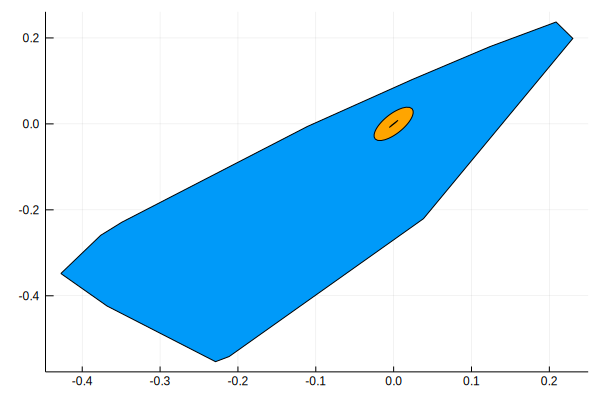

In [6]:
using Plots
plot(project(safe_set, [2, 3]))
plot!(project(max_vol_sym_ell, [2, 3]), color=:orange)
plot!(project(max_tr_sym_ell, [2, 3]), color=:green)

We can see that forcing the center of the ellipsoid to coincide with the Chebyshev center of the safe set is quite conservative.
We can ask instead to search for any ellipsoid with the chebyshev of the safe set in its interior.
To avoid having to solve Bilinear Matrix Inequalities, we set the S-procedure scaling to `1.0`.

In [7]:
using SwitchOnSafety
variable = Ellipsoid(point = SetProg.InteriorPoint(cheby_center))
max_vol_ell = invariant_set(system, solver, variable, λ = 1.0)

MOI.get(model, MOI.SolveTime()) = 0.0040400028228759766
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 7.847834132726155e-9


SetProg.Sets.PerspectiveDual{Float64,SetProg.Sets.Householder{Float64,SetProg.Sets.ShiftedEllipsoid{Float64},Float64}}(SetProg.Sets.Householder{Float64,SetProg.Sets.ShiftedEllipsoid{Float64},Float64}(SetProg.Sets.ShiftedEllipsoid{Float64}([4.5620305492011995e-9 8.162541188350911e-10 2.790250632136661e-9; 8.162541188350911e-10 4.555538531834499e-9 4.067869789906437e-9; 2.790250632136661e-9 4.067869789906437e-9 1.1079492203081527e-8], [5.4357154737469756e-8, 2.4068353376876862e-8, -9.454629820382867e-9], -5.585213805499271e-7), -4.804426775545327e-7z² + 1.6682684321985762e-7zx₁ + 1.8007128827424212e-7zx₂ + 3.271811832191743e-7zx₃ - 4.339202603050428e-9x₁² - 2.4151448867367673e-8x₁x₂ - 5.132919514168793e-8x₁x₃ - 1.0817603486437034e-8x₂² - 5.214577832482907e-8x₂x₃ - 4.272483562178942e-8x₃², [-0.27486640195707857, -0.23076924672696947, -0.31707832793696117], z, DynamicPolynomials.PolyVar{true}[x₁, x₂, x₃]))

Instead of maximizing the volume, we can maximize the L1 norm as above.

In [8]:
using SwitchOnSafety
max_tr_ell = invariant_set(system, solver, variable, λ = 1.0, volume_heuristic = ell -> L1_heuristic(ell, ones(3)))

MOI.get(model, MOI.SolveTime()) = 0.0027611255645751953
JuMP.termination_status(model) = MathOptInterface.OPTIMAL
JuMP.primal_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.dual_status(model) = MathOptInterface.FEASIBLE_POINT
JuMP.objective_value(model) = 1.0967887218967046e-8


SetProg.Sets.PerspectiveDual{Float64,SetProg.Sets.Householder{Float64,SetProg.Sets.ShiftedEllipsoid{Float64},Float64}}(SetProg.Sets.Householder{Float64,SetProg.Sets.ShiftedEllipsoid{Float64},Float64}(SetProg.Sets.ShiftedEllipsoid{Float64}([1.5124997085695024e-9 1.0309449463833013e-9 3.533787610557036e-9; 1.0309449463833013e-9 2.844994843054617e-9 5.002244733926524e-9; 3.533787610557036e-9 5.002244733926524e-9 1.2094336276826453e-8], [5.016305944316213e-8, 2.9672147365134595e-8, 8.309368624307331e-9], -4.4820306719598057e-7), -4.0003679494831796e-7z² + 1.2785323108410327e-7zx₁ + 1.3165652466517716e-7zx₂ + 2.439405723516321e-7zx₃ - 2.8938640622953642e-9x₁² - 1.1750155255237431e-8x₁x₂ - 2.8589796437625344e-8x₁x₃ - 5.645228072914117e-9x₂² - 2.733036476689344e-8x₂x₃ - 2.3175349284002358e-8x₃², [-0.27486640195707857, -0.23076924672696947, -0.31707832793696117], z, DynamicPolynomials.PolyVar{true}[x₁, x₂, x₃]))

We can see that we get a larger ellipsoids for the volume maximization but not for the L1 norm as maximizing the L1 integral over the hypercube centered at the origin is not a very good heuristic. We should instaed maximize the L1 integral over the safe set but this is not implemented yet in [SetProg](https://github.com/blegat/SetProg.jl).

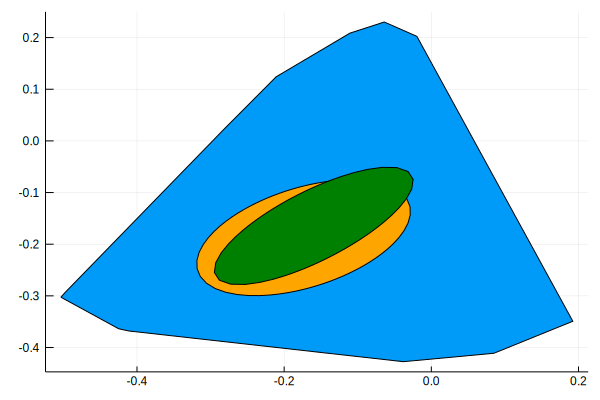

In [9]:
using Plots
plot(project(safe_set, [1, 2]))
plot!(project(max_vol_ell, [1, 2]), color=:orange)
plot!(project(max_tr_ell, [1, 2]), color=:green)

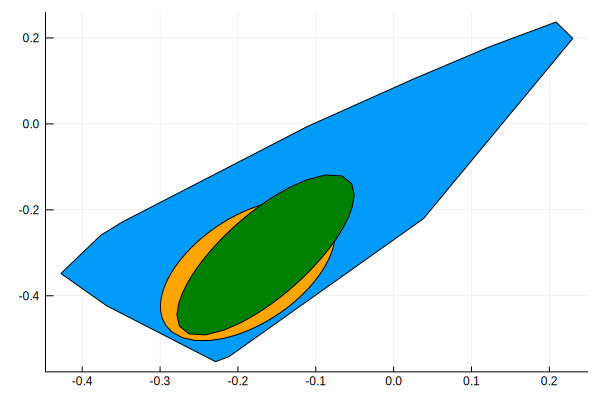

In [10]:
using Plots
plot(project(safe_set, [2, 3]))
plot!(project(max_vol_ell, [2, 3]), color=:orange)
plot!(project(max_tr_ell, [2, 3]), color=:green)

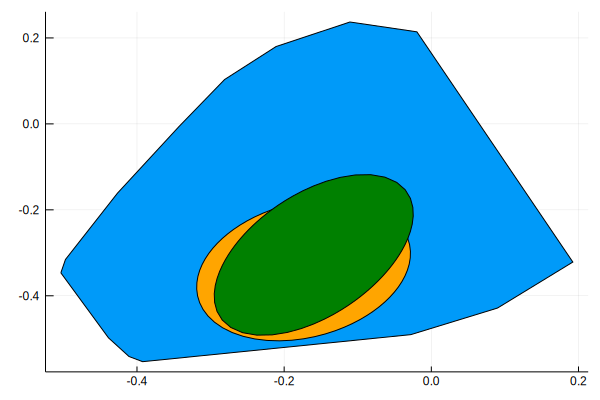

In [11]:
using Plots
plot(project(safe_set, [1, 3]))
plot!(project(max_vol_ell, [1, 3]), color=:orange)
plot!(project(max_tr_ell, [1, 3]), color=:green)